In [ ]:
!pip install --upgrade pip
!pip install opencv-python
!pip install numpy
!pip install "ipython[all]"
!pip install ipywidgets
!pip install pillow

#!pip3 install thread6



TEAMMATES: DANIEL XIAO, AARON ZHENG

In [2]:
import cv2
import numpy as np
from IPython.display import display, Image, clear_output
#import ipywidgets as widgets
import threading
import io
from PIL import Image as PilImage

In [3]:
def show_array(a, fmt='jpeg'):
    f = io.BytesIO()
    PilImage.fromarray(a).save(f, fmt) 
    display(Image(data=f.getvalue()))

def get_video():
    cap = cv2.VideoCapture(0) #0 is the default webcam
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            processed_frame = process_frame(frame)
            frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
            show_array(frame_rgb)
            clear_output(wait=True)
    finally:
        cap.release()


In [4]:
def process_frame(frame):

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    #skin color detection
    lower_skin = np.array([0, 48, 80], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    
    mask = cv2.inRange(hsv, lower_skin, upper_skin)

    #noise filters
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)
    mask = cv2.GaussianBlur(mask, (5, 5), 100)

    #recognition logic
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        hull = cv2.convexHull(max_contour, returnPoints=False)
        defects = cv2.convexityDefects(max_contour, hull)

        count_defects = 0
        if defects is not None:
            for i in range(defects.shape[0]):
                s, e, f, d = defects[i, 0]
                start = np.array(max_contour[s][0]) 
                end = np.array(max_contour[e][0])    
                far = np.array(max_contour[f][0])
                
                a = np.linalg.norm(end - start)
                b = np.linalg.norm(far - start)
                c = np.linalg.norm(end - far)
                
                angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  #cosine theorem

                if angle <= np.pi / 2:
                    count_defects += 1
                    cv2.circle(frame, tuple(far), 5, [0, 0, 255], -1)

        #display logic
        cv2.drawContours(frame, [max_contour], -1, (0, 255, 0), 3)

        #classification logic
        if count_defects >= 4:
            cv2.putText(frame, "Palm", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
        elif count_defects == 3:
            cv2.putText(frame, "4 Fingers up", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
        elif count_defects == 2:
            cv2.putText(frame, "3 Fingers up", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
        elif count_defects == 1:
            cv2.putText(frame, "2 Fingers up", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)
        elif count_defects <= 1:
            cv2.putText(frame, "Fist or 1 Finger up", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2, cv2.LINE_AA)

    return frame



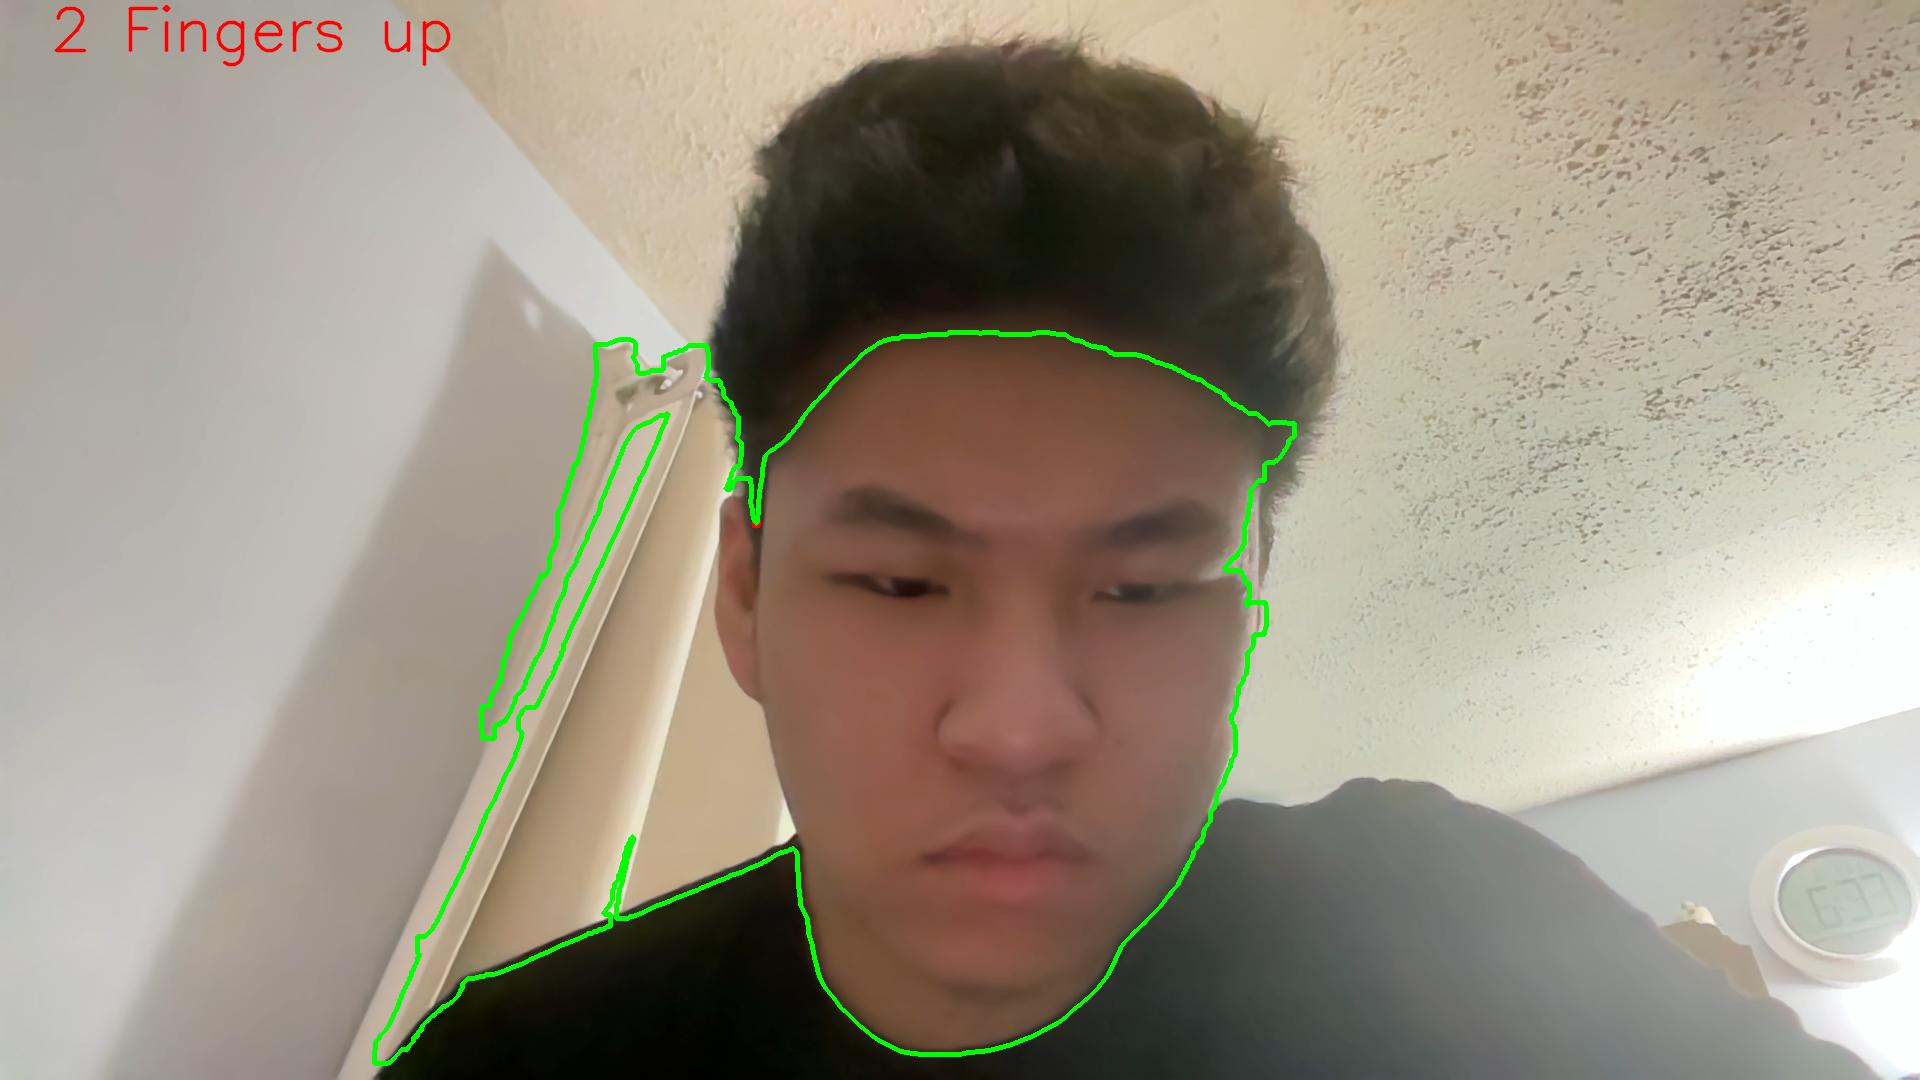

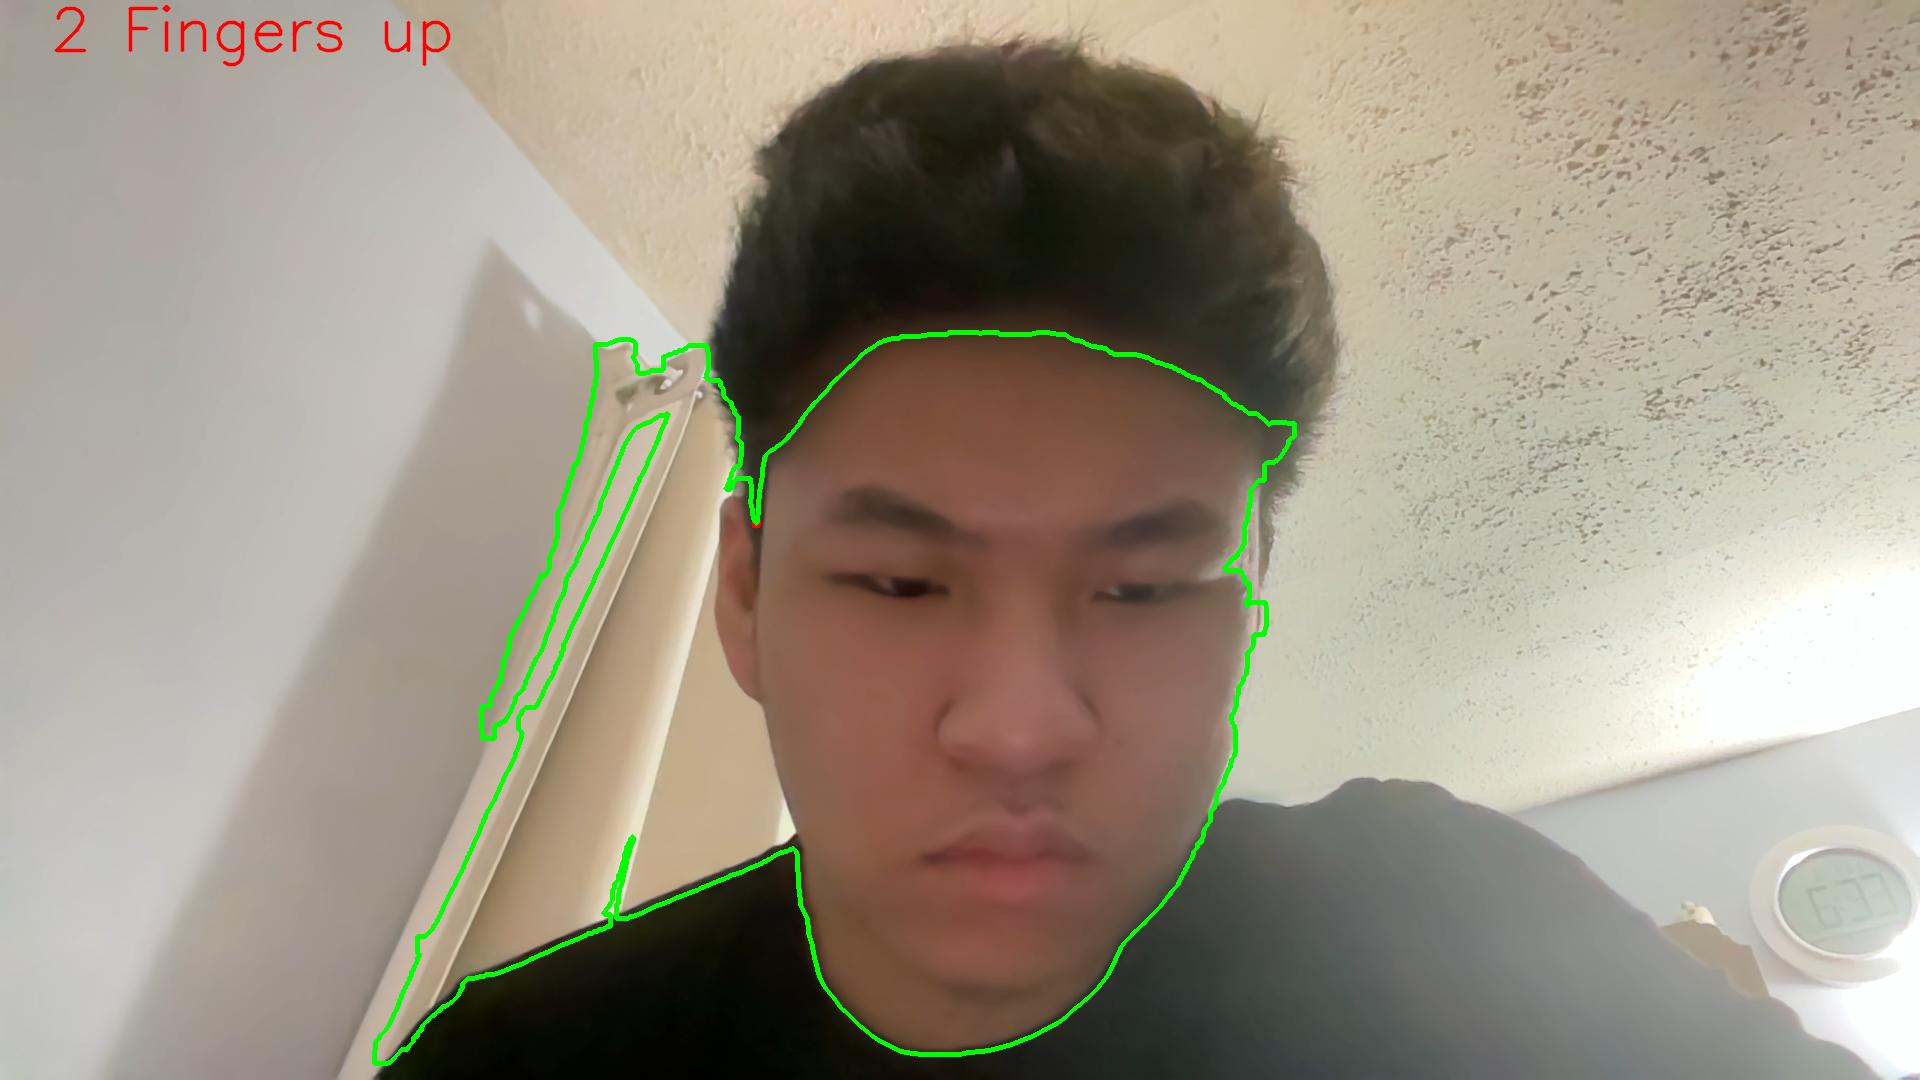

In [ ]:
thread = threading.Thread(target=get_video, args=())
thread.start()
